In [1]:
import pandas as pd
import numpy as np
from time_series_transform.tensorflow_adopter import *
import time_series_transform.base as base
from time_series_transform.time_series_transformer import *
from sklearn.preprocessing import StandardScaler
from time_series_transform.tensorflow_adopter import *
from time_series_transform.stock_transform.base import *
from time_series_transform.stock_transform.stock_extractor import Portfolio_Extractor
from time_series_transform.util import *
from matplotlib import pyplot as plt

In [2]:
tickList = ['^GSPC','^DJI','GC=F','CL=F']
pe = Portfolio_Extractor(tickList,'yahoo')
port = pe.get_portfolio_period('5yr')

AttributeError: 'str' object has no attribute 'ticker'

In [3]:
port.make_technical_indicator('Close','diff_1',differencing)
port.make_technical_indicator('Close_diff_1','fft10000',rfft_transform,threshold = 10000)
port.make_technical_indicator('Close_diff_1','fft1000',rfft_transform,threshold = 1000)
port.make_technical_indicator('Close_diff_1','fft100',rfft_transform,threshold = 100)
port.make_technical_indicator('Close_diff_1','moving_3',moving_average,windowSize = 3)
port.make_technical_indicator('Close_diff_1','moving_30',moving_average,windowSize = 30)
port.make_technical_indicator('Close_diff_1','wavelet_6',wavelet_denoising,level =6)
port.make_technical_indicator('Close_diff_1','wavelet_1',wavelet_denoising,level =1)
port.make_technical_indicator('Close','wavelet_1',wavelet_denoising,level =1)

In [4]:
df = port.get_portfolio_dataFrame()

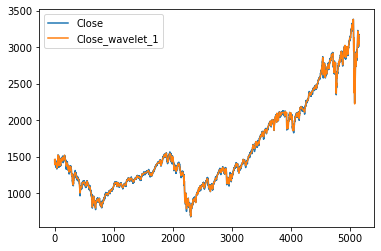

In [5]:
df[['Close','Close_wavelet_1']].plot()

In [6]:
trainDate = list(range(2000,4800))
valDate = list(range(4800,4900))
testDate = list(range(4900,5000))
labels = [
    'sp500_Close_diff_1',
    'sp500_Close_wavelet_1',
    'sp500_Close_diff_1_wavelet_6',
    'sp500_Close_diff_1_wavelet_1'
         ]
WINDOW_SIZE = 30

In [7]:
resDf = port.get_portfolio_dataFrame()
psd = Pandas_Time_Series_Tensor_Dataset(resDf)
timeSeriesDic = psd.expand_dataFrame_by_date('symbol','Date',True,False,True)
for i,v in enumerate(labels):
    if i == 0:
        psd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',trainDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',trainDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )

for step in range(1):
    if step == 0:
        psd.set_config(
            name = 'label',
            colNames = list(map(lambda x: f'sp500_Close_{str(x)}',trainDate)),
            tensorType = 'label',
            sequence_stack = None,
            isResponseVar = True,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'label_{step}',
            colNames = list(map(lambda x: f'sp500_Close_{str(x)}',map(lambda x: x+step ,trainDate))),
            tensorType = 'label',
            sequence_stack = 'label',
            isResponseVar = True,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )        

In [8]:
gen = psd.make_data_generator()
tfg = TFRecord_Writer('abc.tfRecord')
tfg.write_tfRecord(gen)
dtypeRecord_train = tfg.get_tfRecord_dtype()

In [9]:
psd = Pandas_Time_Series_Tensor_Dataset(resDf)
timeSeriesDic = psd.expand_dataFrame_by_date('symbol','Date',True,False,True)
for i,v in enumerate(labels):
    if i == 0:
        psd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',valDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',valDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )

for step in range(1):
    if step == 0:
        psd.set_config(
            name = 'label',
            colNames = list(map(lambda x: f'sp500_Close_{str(x)}',valDate)),
            tensorType = 'label',
            sequence_stack = None,
            isResponseVar = True,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'label_{step}',
            colNames = list(map(lambda x: f'sp500_Close_{str(x)}',map(lambda x: x+step ,valDate))),
            tensorType = 'label',
            sequence_stack = 'label',
            isResponseVar = True,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )     

In [10]:
gen = psd.make_data_generator()
tfg = TFRecord_Writer('abc_val.tfRecord')
tfg.write_tfRecord(gen)
dtypeRecord_val = tfg.get_tfRecord_dtype()

In [11]:
tfr_train = TFRecord_Reader('abc.tfRecord',dtypeRecord_train)
tfr_val = TFRecord_Reader('abc_val.tfRecord',dtypeRecord_val)

In [12]:
def data_transform(X):
    # we only use the current week day and current price as feature
    # ignore the rest of data within the window since the change is very limited.
    X['current'] = X['sequence'][:,:-28,:]
    X['past'] = X['sequence'][:,-28:,:]
    Y = X['label']
    return (X,Y)

In [55]:
EVALUATION_INTERVAL = 250
Validation_STEP =  250
EPOCHS = 100


train_dataset = tfr_train.make_tfDataset()
val_dataset = tfr_val.make_tfDataset()
batchsize = 1000

train_dataset = train_dataset.unbatch().batch(3000).map(data_transform).\
prefetch(tf.data.experimental.AUTOTUNE).repeat()
val_dataset = val_dataset.unbatch().batch(3000).map(data_transform).\
prefetch(tf.data.experimental.AUTOTUNE).repeat()

In [93]:
def create_attention_model():
    seq_input = tf.keras.layers.Input(shape=(WINDOW_SIZE,len(labels)),name = 'sequence')
    
    # lstm
#     seq = tf.keras.layers.LayerNormalization()(seq_input)
#     seq = tf.keras.layers.LSTM(1,return_sequences=False)(seq)
    
    #2d cnn
#     seq = tf.keras.layers.Reshape((20,20,len(labels)))(seq_input)
#     seq = tf.keras.layers.BatchNormalization()(seq)
#     seq = tf.keras.layers.Conv2D(5,(11,11),activation = 'relu')(seq)
#     seq = tf.keras.layers.MaxPooling2D((2,2))(seq)
#     seq = tf.keras.layers.BatchNormalization()(seq)
#     seq = tf.keras.layers.Conv2D(5,(2,2),activation = 'relu')(seq)
#     seq = tf.keras.layers.MaxPooling2D((2,2))(seq)
    
    #1d cnn
    seq = tf.keras.layers.BatchNormalization()(seq_input)
    seq = tf.keras.layers.Conv1D(3,10,activation = 'elu')(seq)
    seq = tf.keras.layers.MaxPooling1D(2)(seq)

    seq = tf.keras.layers.Flatten()(seq_input)
    seq = tf.keras.layers.Dense(50,'relu')(seq)
    seq = tf.keras.layers.Dropout(0.1)(seq)
    seq = tf.keras.layers.Dense(20,'relu')(seq)
    seq = tf.keras.layers.Dense(1)(seq)
    

    
    lstm_embed = tf.keras.models.Model({
        "sequence":seq_input
                                       },
                                       seq)

    rmse = tf.keras.metrics.RootMeanSquaredError()
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    huber = tf.keras.losses.Huber()
    adam = tf.keras.optimizers.Adam(lr = 0.001,
                                    decay = 0.0001,
                                    amsgrad = True
                                   )
    rmsp = tf.keras.optimizers.RMSprop(learning_rate=0.01, 
                                       rho=0.9)


    lstm_embed.compile(optimizer=rmsp, 
                       loss='mae',
                       metrics = ['mae','mse',rmse
                                 ]
                      )
    return lstm_embed

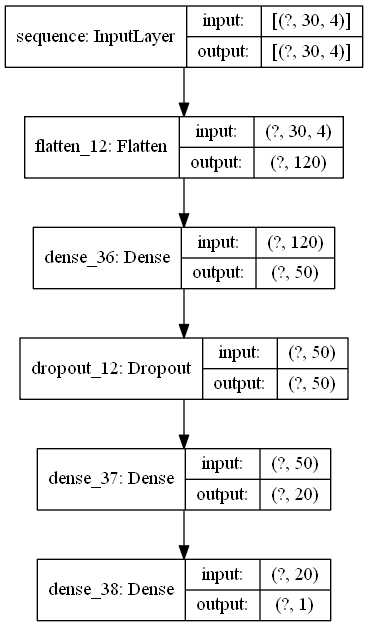

In [94]:
model = create_attention_model()
tf.keras.utils.plot_model(
    model, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [95]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    min_delta=0.001, 
    patience=50, 
    verbose=1, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)
model.fit(train_dataset,
          epochs=500,
          verbose = 2,
          validation_data = val_dataset,
          validation_steps=1,
          steps_per_epoch=10,
          callbacks= [early_stopping]
     )

Train for 10 steps, validate for 1 steps
Epoch 1/500
10/10 - 1s - loss: 883.7638 - mae: 883.7639 - mse: 1630862.3750 - root_mean_squared_error: 1277.0522 - val_loss: 1021.2752 - val_mae: 1021.2752 - val_mse: 1045824.6875 - val_root_mean_squared_error: 1022.6557
Epoch 2/500
10/10 - 0s - loss: 402.7148 - mae: 402.7148 - mse: 219687.5156 - root_mean_squared_error: 468.7083 - val_loss: 754.8698 - val_mae: 754.8698 - val_mse: 572603.5625 - val_root_mean_squared_error: 756.7057
Epoch 3/500
10/10 - 0s - loss: 358.4696 - mae: 358.4696 - mse: 169865.9375 - root_mean_squared_error: 412.1479 - val_loss: 820.8891 - val_mae: 820.8891 - val_mse: 676303.0625 - val_root_mean_squared_error: 822.3765
Epoch 4/500
10/10 - 0s - loss: 344.6115 - mae: 344.6115 - mse: 160120.3125 - root_mean_squared_error: 400.1504 - val_loss: 665.3701 - val_mae: 665.3701 - val_mse: 445322.4375 - val_root_mean_squared_error: 667.3248
Epoch 5/500
10/10 - 0s - loss: 314.9224 - mae: 314.9225 - mse: 131415.9844 - root_mean_square

Epoch 39/500
10/10 - 0s - loss: 140.4818 - mae: 140.4818 - mse: 35440.4414 - root_mean_squared_error: 188.2563 - val_loss: 595.4196 - val_mae: 595.4196 - val_mse: 355701.4375 - val_root_mean_squared_error: 596.4071
Epoch 40/500
10/10 - 0s - loss: 141.3177 - mae: 141.3177 - mse: 34595.3086 - root_mean_squared_error: 185.9981 - val_loss: 648.1545 - val_mae: 648.1545 - val_mse: 421271.3438 - val_root_mean_squared_error: 649.0542
Epoch 41/500
10/10 - 0s - loss: 138.7785 - mae: 138.7785 - mse: 34360.1484 - root_mean_squared_error: 185.3649 - val_loss: 638.3522 - val_mae: 638.3522 - val_mse: 408635.9062 - val_root_mean_squared_error: 639.2463
Epoch 42/500
10/10 - 0s - loss: 140.0434 - mae: 140.0434 - mse: 35130.5391 - root_mean_squared_error: 187.4314 - val_loss: 636.1301 - val_mae: 636.1301 - val_mse: 405776.6875 - val_root_mean_squared_error: 637.0060
Epoch 43/500
10/10 - 0s - loss: 138.4506 - mae: 138.4505 - mse: 35005.6367 - root_mean_squared_error: 187.0979 - val_loss: 587.0898 - val_ma

In [96]:
prd = model.predict(train_dataset,steps = 1)
val_prd = model.predict(val_dataset, steps=1)

In [97]:
def plot_diff(prcd,resDf,label,step):
    real = resDf[list(map(lambda x: f'sp500_Close_{x}',label))].transpose().values
    plotDf = pd.DataFrame(real[step:]).tail(len(prcd[step]))
    plotDf['prd_Close'] = prcd[step]
    return plotDf
def plot_diff(prcd,resDf,label,step):
    real = resDf[list(map(lambda x: f'sp500_Close_{x}',label))].transpose().values
    plotDf = pd.DataFrame(real).tail(len(prcd))
    plotDf['prd_Close'] = prcd
    return plotDf

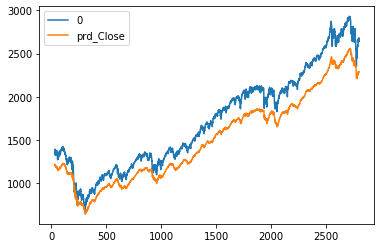

In [98]:
plotDf = plot_diff(prd,psd.df,trainDate,0)
plotDf.plot()

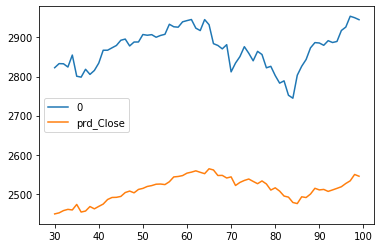

In [99]:
plotDf = plot_diff(val_prd,psd.df,valDate,20)
plotDf.plot()

In [21]:
tpsd = Pandas_Time_Series_Tensor_Dataset(df)
timeSeriesDic = tpsd.expand_dataFrame_by_date('symbol','Date')
for i,v in enumerate(labels):
    if i == 0:
        tpsd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',testDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        tpsd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',testDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
        
tpsd.set_config(
    name = 'label',
    colNames = list(map(lambda x: f'sp500_Close_{str(x)}',testDate)),
    tensorType = 'label',
    sequence_stack = None,
    isResponseVar = True,
    windowSize = WINDOW_SIZE,
    seqSize = 1837,
    outType = np.float32
)

In [22]:
tgen = psd.make_data_generator()
test_prediction = model.predict(tgen)

In [23]:
plotDf = plot_diff(test_prediction,tpsd.df,testDate)
plotDf.plot()

KeyError: "None of [Index(['sp500_Close_4900', 'sp500_Close_4901', 'sp500_Close_4902',\n       'sp500_Close_4903', 'sp500_Close_4904', 'sp500_Close_4905',\n       'sp500_Close_4906', 'sp500_Close_4907', 'sp500_Close_4908',\n       'sp500_Close_4909', 'sp500_Close_4910', 'sp500_Close_4911',\n       'sp500_Close_4912', 'sp500_Close_4913', 'sp500_Close_4914',\n       'sp500_Close_4915', 'sp500_Close_4916', 'sp500_Close_4917',\n       'sp500_Close_4918', 'sp500_Close_4919', 'sp500_Close_4920',\n       'sp500_Close_4921', 'sp500_Close_4922', 'sp500_Close_4923',\n       'sp500_Close_4924', 'sp500_Close_4925', 'sp500_Close_4926',\n       'sp500_Close_4927', 'sp500_Close_4928', 'sp500_Close_4929',\n       'sp500_Close_4930', 'sp500_Close_4931', 'sp500_Close_4932',\n       'sp500_Close_4933', 'sp500_Close_4934', 'sp500_Close_4935',\n       'sp500_Close_4936', 'sp500_Close_4937', 'sp500_Close_4938',\n       'sp500_Close_4939', 'sp500_Close_4940', 'sp500_Close_4941',\n       'sp500_Close_4942', 'sp500_Close_4943', 'sp500_Close_4944',\n       'sp500_Close_4945', 'sp500_Close_4946', 'sp500_Close_4947',\n       'sp500_Close_4948', 'sp500_Close_4949', 'sp500_Close_4950',\n       'sp500_Close_4951', 'sp500_Close_4952', 'sp500_Close_4953',\n       'sp500_Close_4954', 'sp500_Close_4955', 'sp500_Close_4956',\n       'sp500_Close_4957', 'sp500_Close_4958', 'sp500_Close_4959',\n       'sp500_Close_4960', 'sp500_Close_4961', 'sp500_Close_4962',\n       'sp500_Close_4963', 'sp500_Close_4964', 'sp500_Close_4965',\n       'sp500_Close_4966', 'sp500_Close_4967', 'sp500_Close_4968',\n       'sp500_Close_4969', 'sp500_Close_4970', 'sp500_Close_4971',\n       'sp500_Close_4972', 'sp500_Close_4973', 'sp500_Close_4974',\n       'sp500_Close_4975', 'sp500_Close_4976', 'sp500_Close_4977',\n       'sp500_Close_4978', 'sp500_Close_4979', 'sp500_Close_4980',\n       'sp500_Close_4981', 'sp500_Close_4982', 'sp500_Close_4983',\n       'sp500_Close_4984', 'sp500_Close_4985', 'sp500_Close_4986',\n       'sp500_Close_4987', 'sp500_Close_4988', 'sp500_Close_4989',\n       'sp500_Close_4990', 'sp500_Close_4991', 'sp500_Close_4992',\n       'sp500_Close_4993', 'sp500_Close_4994', 'sp500_Close_4995',\n       'sp500_Close_4996', 'sp500_Close_4997', 'sp500_Close_4998',\n       'sp500_Close_4999'],\n      dtype='object')] are in the [columns]"

In [24]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(plotDf[0],plotDf.prd_High))

AttributeError: 'DataFrame' object has no attribute 'prd_High'